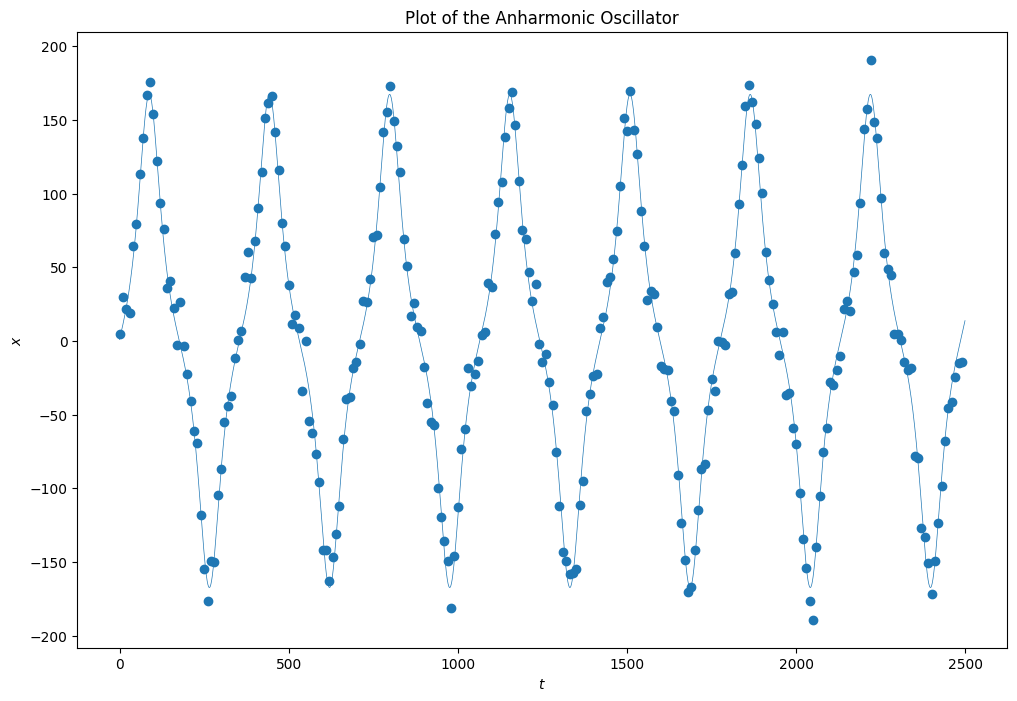

In [8]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.linalg import fractional_matrix_power
from scipy.stats import norm

'''Discrete model approximating the anharmonic oscillator, this derivation comes from finite differencing of the continuous system'''
rng = np.random.default_rng()

sigma = 100 #standard deviation of the observation noise

x_0 = 0 
x_1 = 1

omega = 3.5 * 10**-2
lam = 3 * 10**-4

M = lambda u_k: np.array([
    [2 + omega**2 - lam**2 * u_k[0]**2, -1],
    [1,                               0]])

H = np.array([[1,0]])

N = 2500 #Number of time-points for which to simulate the system 

delta_t = 10

U = np.zeros((2,N)) #State is described by x_k and x_k-1
Y = np.zeros((1,N // delta_t)) #Observation is x_k 

R_o = sigma * np.array([[1]]) #observation noise
t_dis = np.arange(0,N,delta_t)

U[0,0] = x_1
U[1,0] = x_0

y_index = 0
for k in range(0,N-1): 
   U[:,k+1] = M(U[:,k]) @ U[:,k]

   if(k % delta_t == 0): 
    Y[:,y_index] = H @ U[:,k]
    y_index += 1


Y = Y + rng.multivariate_normal([0],R_o,size = np.size(Y)).squeeze()

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot()
ax.plot(U[0, :],linewidth = 0.5)
ax.scatter(t_dis,Y.squeeze())
ax.set_ylabel("$x$")
ax.set_xlabel("$t$")
ax.set_title("Plot of the Anharmonic Oscillator")
plt.show()

In [9]:
num_particles = 1000

In [10]:
'''Lin Domain Particle Filter'''

x0 = np.array([1,0])  # Initial state (equilibrium)

proc_noise = 0.1 * np.eye(2)

particle_states = np.zeros((num_particles,2)) # particle array
particle_obs = np.zeros(num_particles)

m_post = np.zeros((2, len(t_dis))) # posterior means

weights = np.ones(num_particles) #weights associated with each particle

'''Setup each particle with an initial state as generated from the prior'''

particle_states = rng.multivariate_normal(x0,np.eye(2),num_particles).T
particle_obs = H @ particle_states


'''Set the weights for each particle in the initial swarm and normalize'''
weights = norm.pdf(Y[:,0],loc=particle_obs,scale = R_o).squeeze()
weights /= np.sum(weights)

'''Resample the weights'''

indices = np.arange(num_particles) #create a cumulative ndarray from 0 to particle_count

#The numpy resampling algorithm, see jupyter notebnook resampling.ipynb for more details
resampling_indices = rng.choice(a=indices, size=num_particles, replace=True, p=weights.squeeze())

particle_states_copy = np.copy(particle_states)

particle_states = particle_states_copy[:,resampling_indices]

m_post[:,0] = np.average(particle_states,axis = 1,weights = weights)

# The particle filter is run for the rest of the time steps.
for i_time in range(0, len(t_dis)-1):
    
    '''Simulate one time step for each particle and set the observations'''
    for index in range(np.shape(particle_states)[1]):
        for _ in range(delta_t):
            particle_states[:,index] = M(particle_states[:,index]) @ particle_states[:,index] #+ rng.multivariate_normal([0,0],proc_noise)

    particle_obs = H @ particle_states + rng.multivariate_normal([0],R_o)

    '''Set the weights for each particle in the swarm and normalize'''
    weights = norm.pdf(Y[:,i_time],loc=particle_obs,scale = R_o).squeeze()
    weights += 10 **-300
    weights /= np.sum(weights)

    cdf = np.cumsum(weights)
        
    '''Resample the weights'''

    i = 0
    resampling_indices = np.zeros(num_particles).astype(int)
    u = rng.uniform(0,1/num_particles)
    for j in range(0,num_particles): 
        r = u + 1/num_particles * j
        while r > cdf[i]: 
            i += 1
        resampling_indices[j] = i

    particle_states_copy = np.copy(particle_states)
    particle_states = particle_states_copy[:,resampling_indices]

    m_post[:,i_time+1] = np.average(particle_states,axis=1,weights = weights)

#compute RMSE
rmse = np.sqrt(np.mean((U[:,np.arange(N // delta_t)] - m_post)**2,axis = 1))
print(rmse)



[121.35208938 121.13623297]


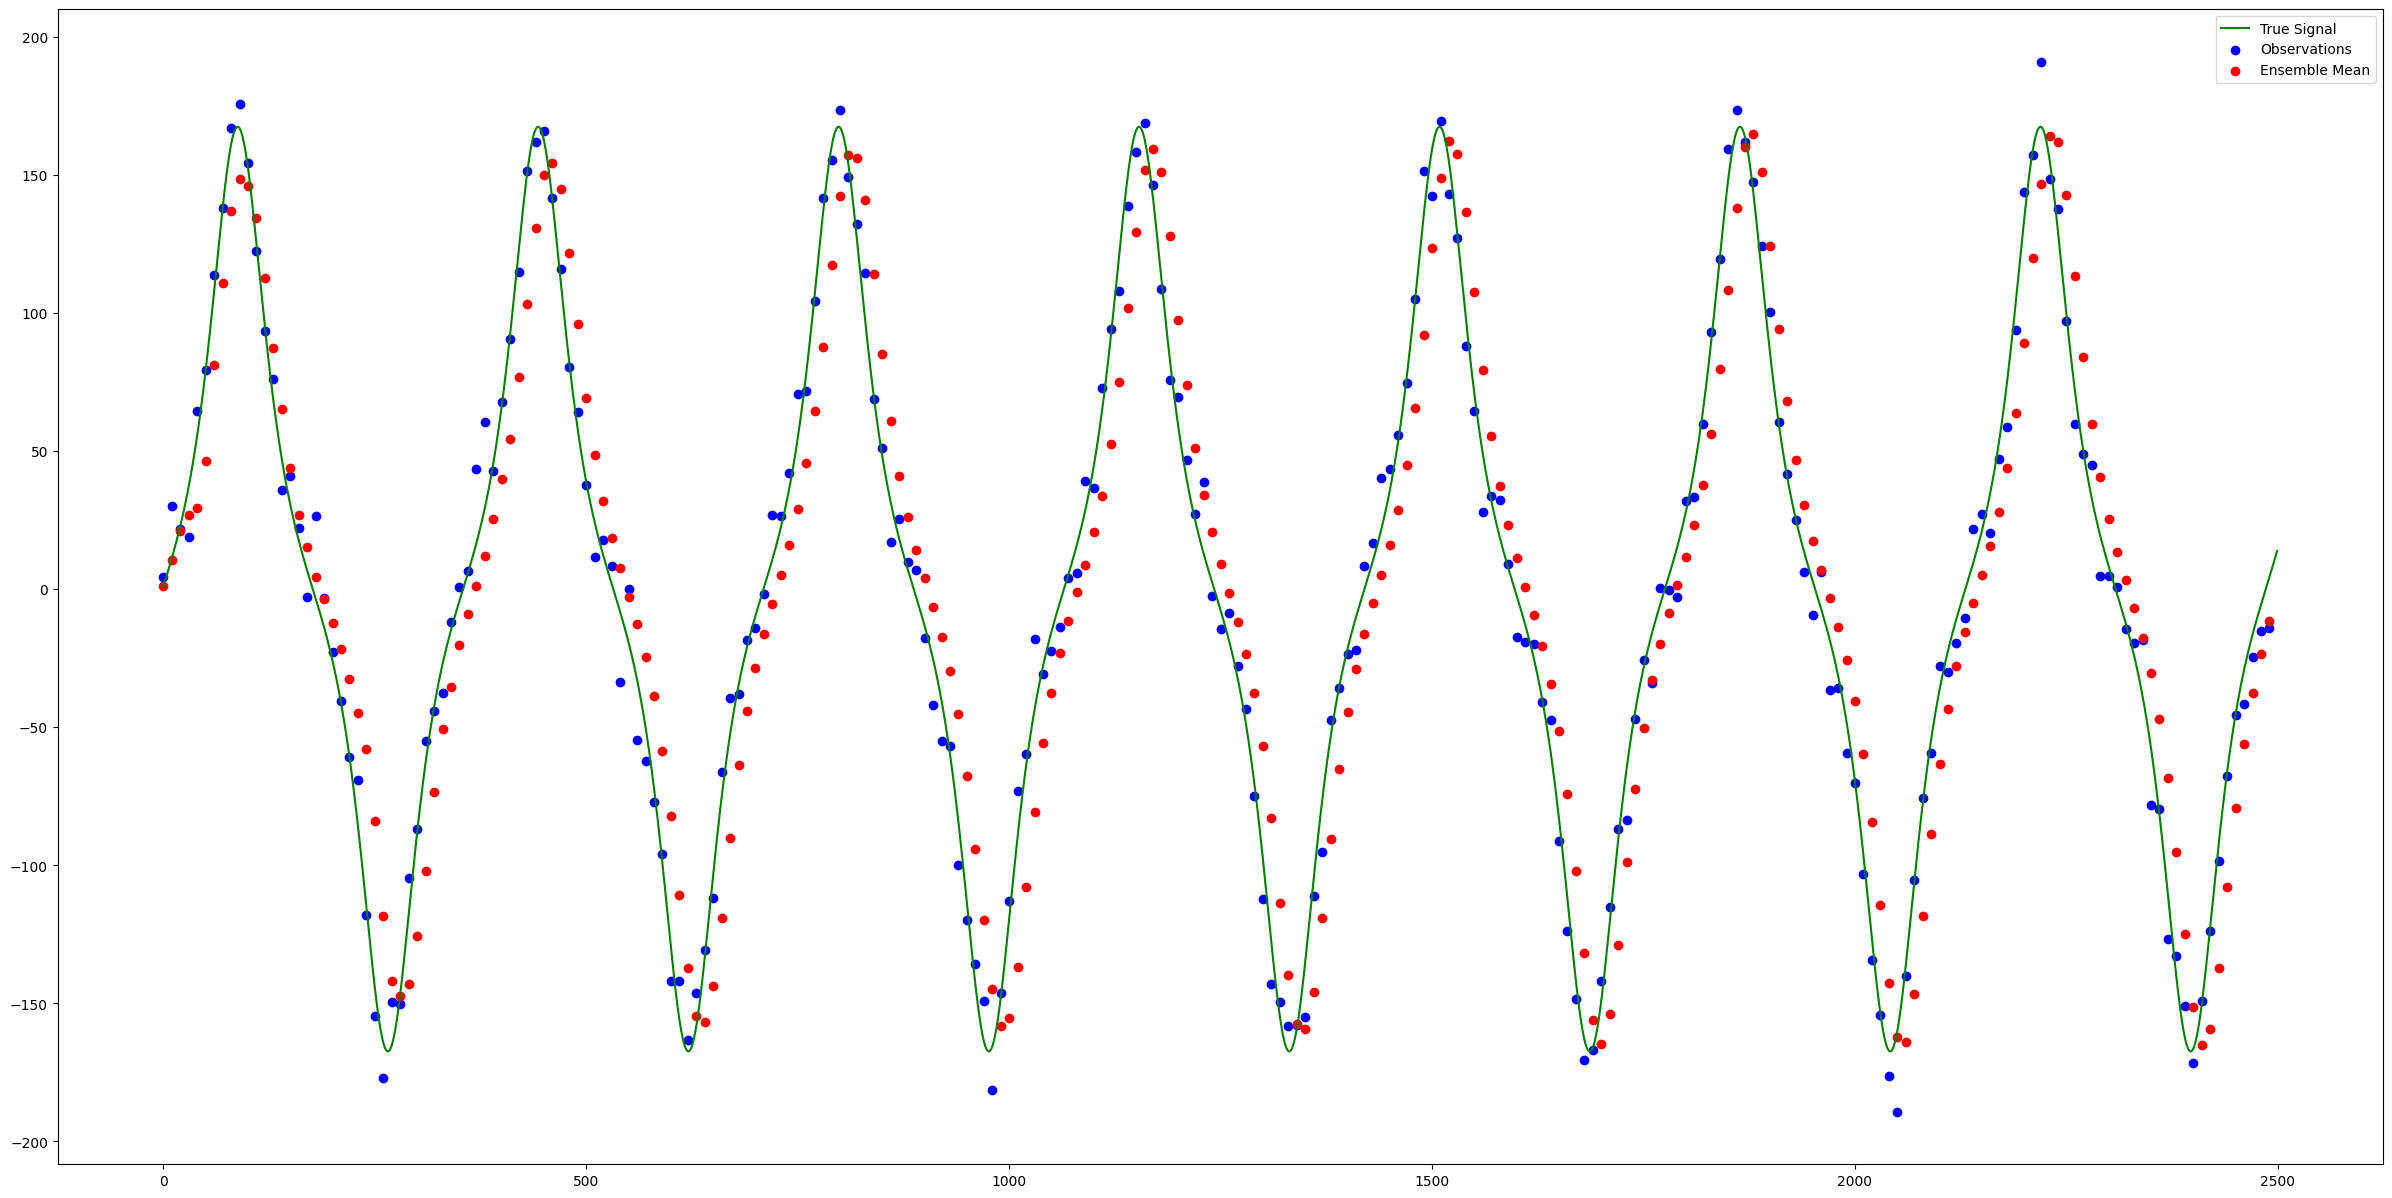

In [11]:
# Plot the first three variables
# The true signal is plotted in red
# The ensemble Kalman filter estimate is plotted in blue
fig = plt.figure(figsize=(30,15))

rows = 1
cols = 1

axes = fig.subplots(rows, cols)

axes.plot(U[0, :],color = 'green',label = 'True Signal')
axes.scatter(t_dis,Y.squeeze(),color = 'blue',label = 'Observations')
axes.scatter(t_dis,m_post[0,:],color = 'red',label = 'Ensemble Mean')
axes.legend()

In [12]:
def jacob(δ):
    """The jacobian logarithm, used in log likelihood normalization and resampling processes
    δ will be an array of values. 
    
    Args: 
        δ: An array of values to sum

    Returns: 
        The vector of partial sums of δ.          
    
    """
    n = len(δ)
    Δ = np.zeros(n)
    Δ[0] = δ[0]
    for i in range(1,n):
        Δ[i] = max(δ[i],Δ[i-1]) + np.log(1 + np.exp(-1*np.abs(δ[i] - Δ[i-1])))
    return(Δ)


def log_norm(log_weights): 
    '''normalizes the probability space using the jacobian logarithm as defined in jacob()'''
    norm = (jacob(log_weights)[-1])
    log_weights -= norm
    return log_weights

In [13]:
'''Log Domain Particle Filter'''

x0 = np.array([1,0])  # Initial state (equilibrium)

proc_noise = 0.1 * np.eye(2)

particle_states = np.zeros((num_particles,2)) # particle array
particle_obs = np.zeros(num_particles)

m_post = np.zeros((2, len(t_dis))) # posterior means

weights = np.ones(num_particles) #weights associated with each particle

'''Setup each particle with an initial state as generated from the prior'''

particle_states = rng.multivariate_normal(x0,np.eye(2),num_particles).T
particle_obs = H @ particle_states


'''Set the weights for each particle in the initial swarm and normalize'''
weights = norm.logpdf(Y[:,0],loc=particle_obs,scale = R_o).squeeze()
weights = log_norm(weights)

log_cdf = jacob(weights)
    
'''Resample the weights'''

i = 0
resampling_indices = np.zeros(num_particles).astype(int)
u = rng.uniform(0,1/num_particles)
for j in range(0,num_particles): 
    r = np.log(u + 1/num_particles * j)
    while r > log_cdf[i]: 
        i += 1
    resampling_indices[j] = i

particle_states_copy = np.copy(particle_states)

particle_states = particle_states_copy[:,resampling_indices]

m_post[:,0] = np.average(particle_states,axis = 1,weights = weights)

# The particle filter is run for the rest of the time steps.
for i_time in range(0, len(t_dis)-1):
    
    '''Simulate one time step for each particle and set the observations'''
    for index in range(np.shape(particle_states)[1]):
        for _ in range(delta_t):
            particle_states[:,index] = M(particle_states[:,index]) @ particle_states[:,index] #+ rng.multivariate_normal([0,0],proc_noise)

    particle_obs = H @ particle_states + rng.multivariate_normal([0],R_o)

    '''Set the weights for each particle in the swarm and normalize'''
    weights = norm.logpdf(Y[:,i_time],loc=particle_obs,scale = R_o).squeeze()
    weights = log_norm(weights)

    '''Resample in log domain'''
    log_cdf = jacob(weights)
    
    i = 0
    resampling_indices = np.zeros(num_particles)
    u = rng.uniform(0,1/num_particles)
    for j in range(0,num_particles): 
        r = np.log(u + 1/num_particles * j)
        while r > log_cdf[i]: 
            i += 1
        resampling_indices[j] = i

    resampling_indices=resampling_indices.astype(int)

    particle_states_copy = np.copy(particle_states)
    particle_states = particle_states_copy[:,resampling_indices]

    m_post[:,i_time+1] = np.average(particle_states,axis=1,weights = weights)

#compute RMSE
rmse = np.sqrt(np.mean((U[:,np.arange(N // delta_t)] - m_post)**2,axis = 1))
print(rmse)


[121.07530569 120.85978508]


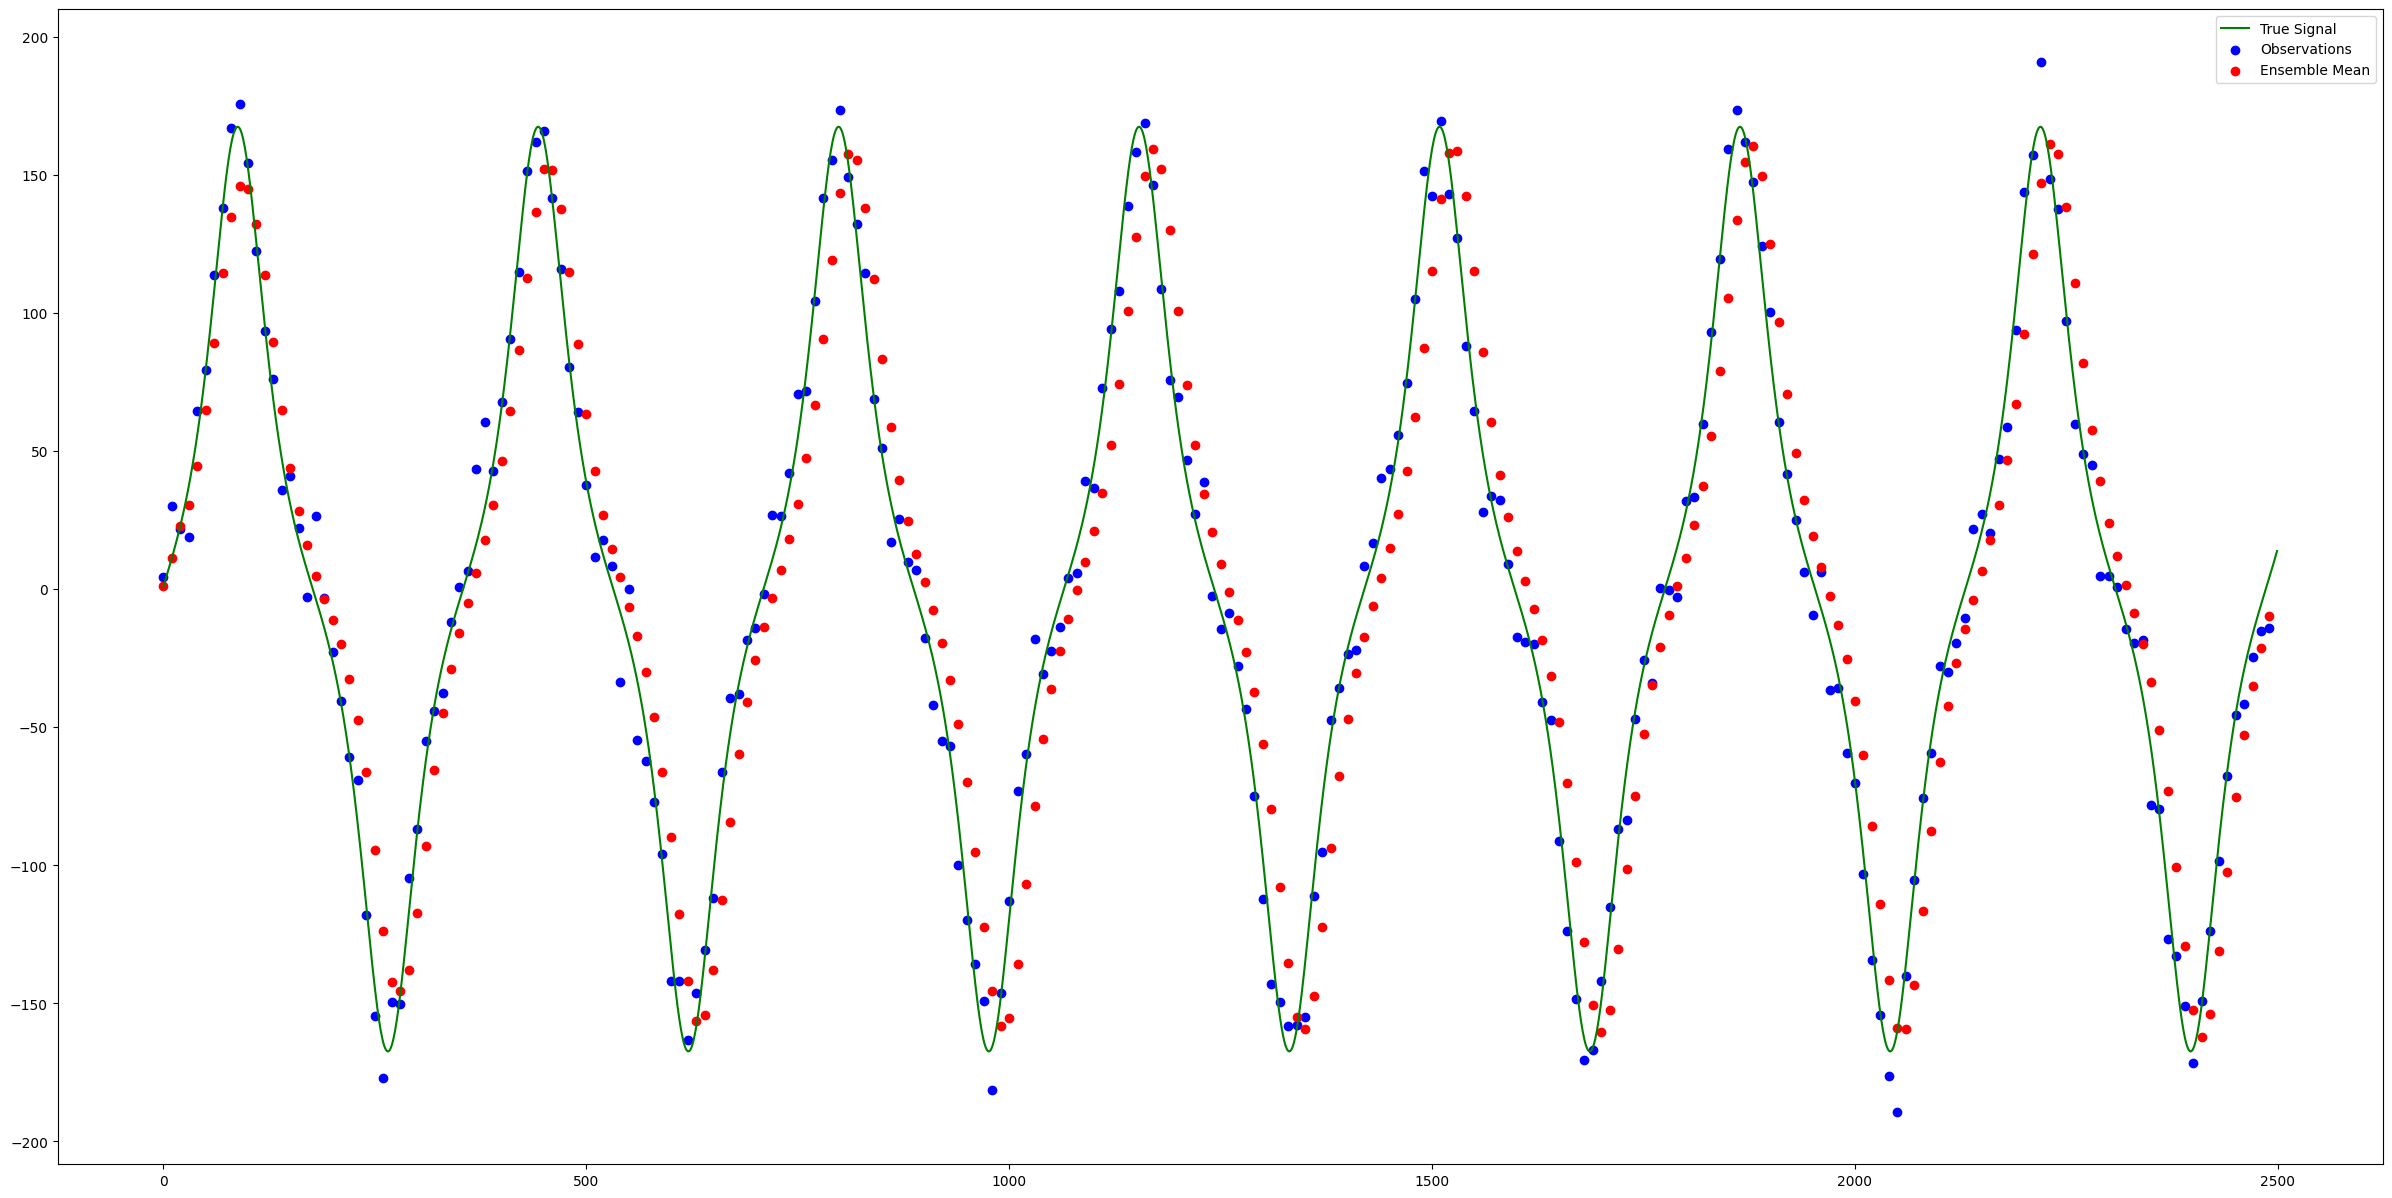

In [14]:
# Plot the first three variables
# The true signal is plotted in red
# The ensemble Kalman filter estimate is plotted in blue
fig = plt.figure(figsize=(30,15))

rows = 1
cols = 1

axes = fig.subplots(rows, cols)

axes.plot(U[0, :],color = 'green',label = 'True Signal')
axes.scatter(t_dis,Y.squeeze(),color = 'blue',label = 'Observations')
axes.scatter(t_dis,m_post[0,:],color = 'red',label = 'Ensemble Mean')
axes.legend()